# **Predicting Concrete Compressive Strength**

### Motivation:
Concrete is a fundamental material in civil engineering. Its compressive strength is important for ensuring the safety and durability of structures. However, determining this strength accurately is challenging because it depends on a nonlinear function between several factors, including the age of the concrete and the proportions of its components—such as cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate, and fine aggregate.
This project aims to apply machine learning techniques to improve the prediction of concrete strength, in order to contribute to better design, quality control, and resource optimization in construction.

### Dataset Explanation:
The dataset is sourced from the UCI Machine Learning Repository and contains 1030 observations with 8 quantitative input variables, and 1 quantitative output variable.
The input variables are: cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate, fine aggregate and age. Except for age, the other variables are ingredient quantities in the concrete mixture and measured in *kg in a $m^{3}$* mixture. The age is measured in *days*.
The target, concrete compressive strengt, is measured in *MPa*.

### Data Analytics: Preprocessing
Since there is no missing attribute values according to the information provided by UCI Machine Learning Repository. Data can be directly read from Concrete_data.csv. 

In [8]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn
import graphviz

from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from itertools import combinations
from IPython.display import display, Math, Image

from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline
plt.style.use('ggplot') 
sns.set_style("darkgrid")
# print numpy arrays with precision 4
np.set_printoptions(precision=4)

In [9]:
concrete_df = pd.read_csv('./Concrete_data.csv', 
                          sep = ',',
                         decimal = ',',
                         encoding = 'UTF-8')
concrete_df.columns = concrete_df.columns.str.strip()
concrete_df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [10]:
print("Original data types：")
print(concrete_df.dtypes)

# object to numeric
for col in concrete_df.columns:
    if concrete_df[col].dtype == 'object':
        concrete_df[col] = pd.to_numeric(concrete_df[col], errors='coerce')


print("\nTransfromed datatypes：")
print(concrete_df.dtypes)

# NaN 
print("\nRows with NaN：", concrete_df.isna().sum().sum())

# Drop NaN
concrete_df = concrete_df.dropna()

Original data types：
Cement (component 1)(kg in a m^3 mixture)                object
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    object
Fly Ash (component 3)(kg in a m^3 mixture)               object
Water  (component 4)(kg in a m^3 mixture)                object
Superplasticizer (component 5)(kg in a m^3 mixture)      object
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     object
Fine Aggregate (component 7)(kg in a m^3 mixture)        object
Age (day)                                                 int64
Concrete compressive strength(MPa, megapascals)          object
dtype: object

Transfromed datatypes：
Cement (component 1)(kg in a m^3 mixture)                float64
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    float64
Fly Ash (component 3)(kg in a m^3 mixture)               float64
Water  (component 4)(kg in a m^3 mixture)                float64
Superplasticizer (component 5)(kg in a m^3 mixture)      float64
Coarse Aggregate  (component 6)(kg in a 

In [11]:
#define all the variables we need for the linear regression with concrete compressive strength as response and all other variables as possible features
label_column = 'Concrete compressive strength(MPa, megapascals)'
feature_columns = [c for c in concrete_df.columns if c != label_column]
X = concrete_df[feature_columns].values
y = concrete_df[label_column].values
p = len(feature_columns)
print("Features are:", feature_columns,
      ", and the response variable is:", label_column)

Features are: ['Cement (component 1)(kg in a m^3 mixture)', 'Blast Furnace Slag (component 2)(kg in a m^3 mixture)', 'Fly Ash (component 3)(kg in a m^3 mixture)', 'Water  (component 4)(kg in a m^3 mixture)', 'Superplasticizer (component 5)(kg in a m^3 mixture)', 'Coarse Aggregate  (component 6)(kg in a m^3 mixture)', 'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)'] , and the response variable is: Concrete compressive strength(MPa, megapascals)


#### Explanation of relevant variables:

The following table shows the meaning and expected effect of respective variables on strength. 
| Variable             | Meaning                              | Expected Effect on Strength    |
| -------------------- | ------------------------------------ | ------------------------------ |
| `cement`             | Binder                               | increases strength          |
| `blast_furnace_slag` | Supplementary binder                 | increases strength or neutral                  |
| `fly_ash`            | Supplementary binder                 | increase strength or neutral                  |
| `water`              | Affects workability and hydration    | decreases strength (excess) |
| `superplasticizer`   | Increases workability, reduces water | increase or decrease depending on context  |
| `coarse_aggregate`   | Filler                               | neutral or mild effect         |
| `fine_aggregate`     | Filler                               | neutral or mild effect         |
| `age`                | Curing time                          | increases strength          |


#### Feature scaling

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 2.4779, -0.8569, -0.8471, ...,  0.8632, -1.2177, -0.2797],
       [ 2.4779, -0.8569, -0.8471, ...,  1.0562, -1.2177, -0.2797],
       [ 0.4914,  0.7955, -0.8471, ..., -0.5265, -2.2409,  3.5531],
       ...,
       [-1.2701,  0.7596,  0.8506, ..., -1.0361,  0.0801, -0.2797],
       [-1.1686,  1.3081, -0.8471, ...,  0.2146,  0.1912, -0.2797],
       [-0.194 ,  0.3085,  0.3769, ..., -1.3951, -0.1507, -0.2797]])

#### Distribution of target variable

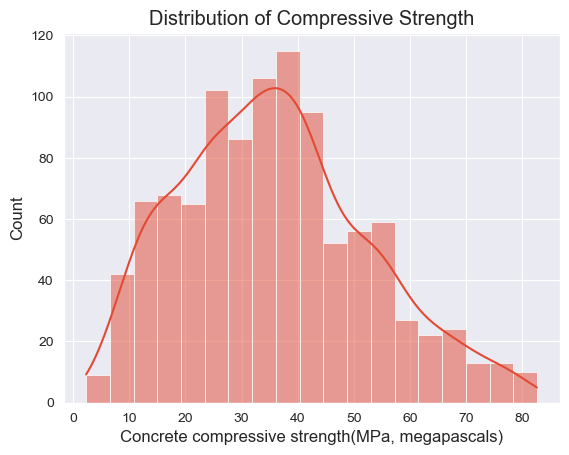

In [13]:
sns.histplot(concrete_df[label_column], kde=True)
plt.title("Distribution of Compressive Strength")
plt.show()

The sns.histplot clearly illustrates that the compressive strength data is not uniformly or normally distributed. Instead, it shows a sporadic and spread-out distribution with many unique or rarely occurring strength values, and potentially some concentrations at the extreme ends of the
measured range.
The data distribution is sparsity, lack of strong central Tendency, so we need to avoid assumption-heavy models (Simple linear regression) and consider robust models (Decision-tree is expected performing the best).
It doesn’t means that we don’t try simple linear regression, but maybe it can tell why linear regression doesn’t perform well

#### Correlation between relevant variables:

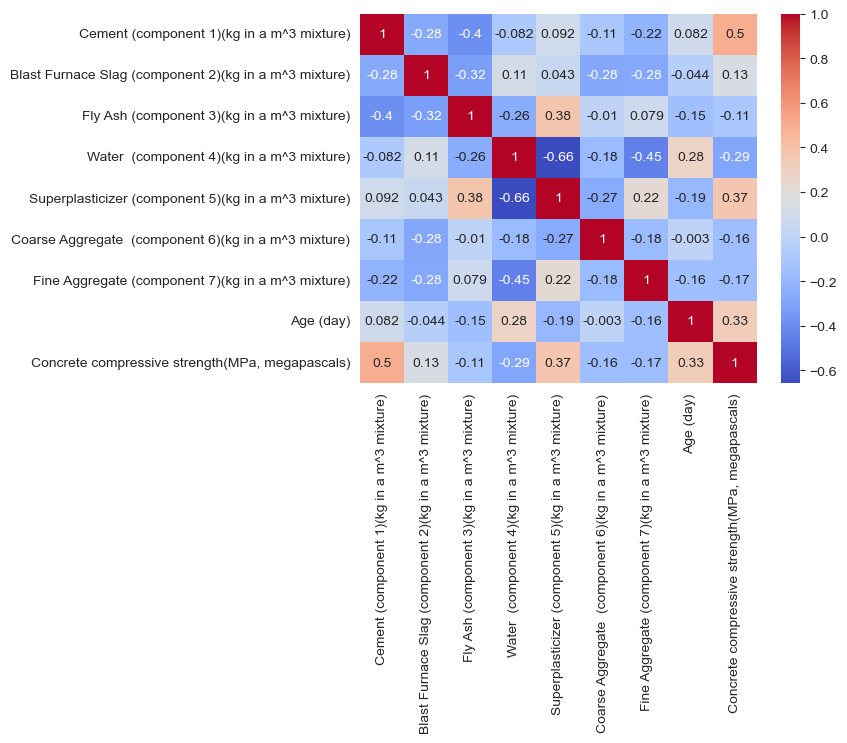

In [14]:
corr = concrete_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

#### Variables that influence concrete strength:

According to the result of the heatmap, it can be seen that **cement** has a moderately strong positive correlation with concrete strength with a value of +0.50, which indicates more cement usually leads to stronger concrete. **Superplasticizer** also has a positive effect with a value of +0.37.
**Age** has a positive effect too , because concrete gets stronger over time.
**Water** has a negative correlation with strength of -0.29, which means more water tends to weaken concrete. This observation is consistent with **Abrams' water-to-cement ratio pronouncement**, which emphasizes that increased water relative to cement typically reduces concrete strength.

#### Multicollinearity:

The highest multicollinearity is the correlation between **water and superplasticizer**, which has a value of -0.66. This indicates they carry overlapping and opposite information. There is also moderate correlation among **cement**, **blast furnace slag**, and **fly ash** because these may act as partial substitutes in the concrete mix, so they tend to move in opposite directions. 

In [15]:
VIFs = [(predictor, variance_inflation_factor(X,_)) \
        for _,predictor in enumerate(list(feature_columns))] 
print('Variance Inflation Factors')
for tup in VIFs:
    print('{:20}'.format(tup[0]), '{:.3f}'.format(tup[1]))

Variance Inflation Factors
Cement (component 1)(kg in a m^3 mixture) 15.457
Blast Furnace Slag (component 2)(kg in a m^3 mixture) 3.329
Fly Ash (component 3)(kg in a m^3 mixture) 4.148
Water  (component 4)(kg in a m^3 mixture) 82.158
Superplasticizer (component 5)(kg in a m^3 mixture) 5.471
Coarse Aggregate  (component 6)(kg in a m^3 mixture) 84.956
Fine Aggregate (component 7)(kg in a m^3 mixture) 72.791
Age (day)            1.699


The variance inflation factors are larger for cement, blast furnace slag, fly ash, water, coarse aggregate, fine aggregate. This also indicates multi-collinearity of the factors mention above.

As mentioned in the lecture content of Machine Learning and Data Analytics(MLDA), VIF equal to 1 shows the absence of collinearity Usually, there is collinearity when VIF is larger than 5.

### Machine Learning Methods:
This project aims to predict concrete compressive strength which is a problem with a quantitative response. According to the lecture content in the fundamental part of MLDA, this task is a **regression task**. In the following part, linear regression, ridge regression, lasso regression, one decision-tree based method are applied. 

### Cross validation:

Validation set approach:

Training and test set split:

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0, shuffle=True)

#### K-fold cross validation:

For supervised machine learning, the goal is to develop a model that can perform accurately not only on the data it was trained on, but also on previously unseen data. To evaluate a model's generalization ability, the **K-fold** method is utilized as the cross validation method.

In [17]:
# define the kfold, shuffle the training and test dataset every time
kf = KFold(n_splits=10, random_state = 0, shuffle = True)

##### Scorers for the model

In [18]:
# Create MSE scorer 
mse_scorer = make_scorer(mean_squared_error)

# Create r2 scorer 
r2 = make_scorer(r2_score)

### Explanation of the dataset with statsmodel:

##### Statsmodel, outliers and high leverege points:

In [19]:
#Statsmodel fitting, it is used to show the p-values
X_stat = sm.add_constant(concrete_df.iloc[:,0:-1])
y_stat = concrete_df[label_column]

statmodel = sm.OLS(y_stat,X_stat)
estimate = statmodel.fit()

print(estimate.summary())

                                           OLS Regression Results                                          
Dep. Variable:     Concrete compressive strength(MPa, megapascals)   R-squared:                       0.616
Model:                                                         OLS   Adj. R-squared:                  0.613
Method:                                              Least Squares   F-statistic:                     204.3
Date:                                             Thu, 19 Jun 2025   Prob (F-statistic):          6.29e-206
Time:                                                     14:04:41   Log-Likelihood:                -3869.0
No. Observations:                                             1030   AIC:                             7756.
Df Residuals:                                                 1021   BIC:                             7800.
Df Model:                                                        8                                         
Covariance Type:            

According to the result of the fitted model, there is a relationship between the response of concrete compressive strength and **cement, blast furnace slag, fly ash, water, superplasticizer and age**, because they have low p-values, which is smaller than 0.05.

Interpretation:

**R-squared:** About 62% of the variance in compressive strength is explained by the model. Decent, but not very high.

**Adj. R-squared:** Adjusted for number of predictors, confirms the model is moderately good.

**F-statistic:** High F -> model is statistically significant overall.

**Prob (F-statstoc):** confirms that the predictors are jointly significant.

Problem:

**Omnibus:** Minor deviation from normality in residuals.

**Durbin-Watson:** is smaller than 2, suggests positive autocorrelation in residuals, which is not ideal, but not catastrophic here.

To improve the model, we will try next step regularized models (e.g. Ridge or Lasso) to deal with correlated predictors, and we will scale the features and use **scikit-learn** for better predictions.

In [20]:
# Obtain the residuals, studentized residuals and the leverages
fitted_values = estimate.fittedvalues
residuals = estimate.resid.values
studentized_residuals = OLSInfluence(estimate).resid_studentized_internal
leverages = OLSInfluence(estimate).influence

Outliers are: [381, 383]
Comments on joint outliers (in both ax2 and ax3): [381, 383]


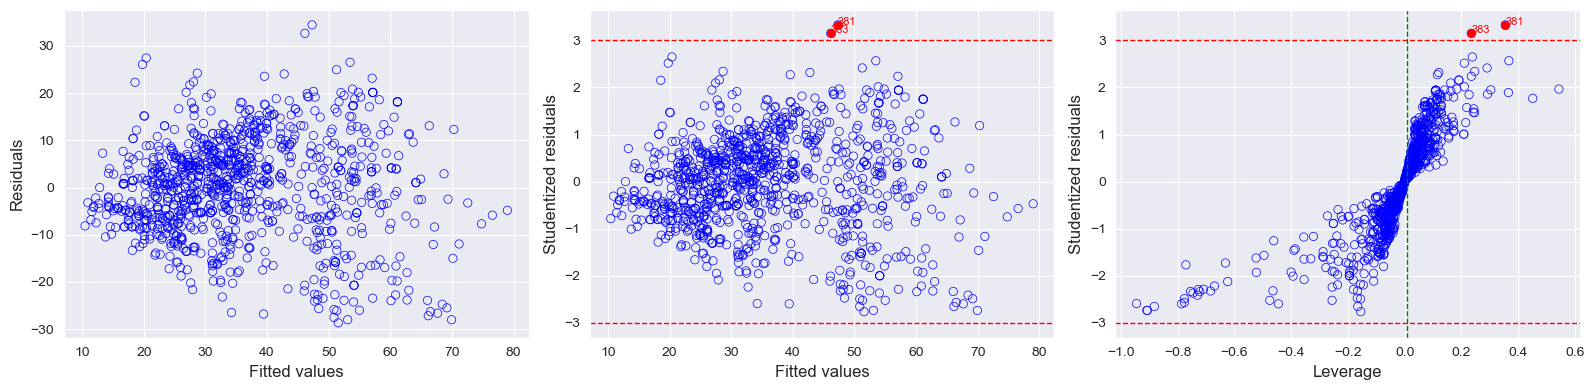

In [21]:
# Calculate thresholds
n = len(fitted_values)
p = X.shape[1] - 1  # exclude constant
leverage_thresh = (p + 1) / n

# Convert to arrays
studentized_residuals = np.asarray(studentized_residuals)
leverages = np.asarray(leverages)

# Identify outlier indices
outlier_indices = np.where(np.abs(studentized_residuals) > 3)[0]
high_leverage_indices = np.where(leverages > leverage_thresh)[0]
outliers = []
for idx in outlier_indices:
    outliers.append(idx)
print("Outliers are:",outliers)

# Find common indices (both outlier and high leverage)
joint_outliers = np.intersect1d(outlier_indices, high_leverage_indices)
high_leverage_and_outliers = [] 

for idx in joint_outliers:
    high_leverage_and_outliers.append(idx)
print("Comments on joint outliers (in both ax2 and ax3):",high_leverage_and_outliers)


# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

# 1. Residuals plot
ax1.scatter(fitted_values, residuals, facecolors='none', edgecolors='b')
ax1.set_xlabel('Fitted values')
ax1.set_ylabel('Residuals')

# 2. Studentized Residuals plot
ax2.scatter(fitted_values, studentized_residuals, facecolors='none', edgecolors='b')
ax2.axhline(y=3, color='r', linestyle='--', linewidth=1)
ax2.axhline(y=-3, color='r', linestyle='--', linewidth=1)
# Mark joint outliers
for idx in joint_outliers:
    ax2.scatter(fitted_values[idx], studentized_residuals[idx], color='red')
    ax2.annotate(idx, (fitted_values[idx], studentized_residuals[idx]), color='red', fontsize=8)
ax2.set_xlabel('Fitted values')
ax2.set_ylabel('Studentized residuals')

# 3. Leverage vs Studentized Residuals
ax3.scatter(leverages, studentized_residuals, facecolors='none', edgecolors='b')
ax3.axhline(y=3, color='r', linestyle='--', linewidth=1)
ax3.axhline(y=-3, color='r', linestyle='--', linewidth=1)
ax3.axvline(x=leverage_thresh, color='g', linestyle='--', linewidth=1)
# Mark joint outliers
for idx in joint_outliers:
    ax3.scatter(leverages[idx], studentized_residuals[idx], color='red')
    ax3.annotate(idx, (leverages[idx], studentized_residuals[idx]), color='red', fontsize=8)
ax3.set_xlabel('Leverage')
ax3.set_ylabel('Studentized residuals')

plt.tight_layout()
plt.show()

The residuals display a clear pattern, which suggests **non-linearity** in the data. The studentized residuals indicate the presence of two outliers. The leverage plot also reveals several high-leverage points—defined as points with leverage greater than $(p+1)/n=9/1030\approx 0.009$. Notably, both outliers are also high-leverage points. However, since the dataset does not clearly define criteria for excluding data points, all observations, including the outliers, are retained for the subsequent analysis.

### Prediction with scikit model

##### Linear Regression:

In [22]:
#Preprocess data by scaling features
scaler = StandardScaler()
model = make_pipeline(scaler, LinearRegression())

mse_scores_lin = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
r2_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=kf)

print("\nAverage MSE across folds:", -np.mean(mse_scores_lin))
print("\nAverage R2 across folds:", np.mean(r2_scores))


Average MSE across folds: 113.39808429409459

Average R2 across folds: 0.5901000482034883


Validation set approach:

In [23]:
linear = model.fit(X_train, y_train)
y_pred = linear.predict(X_test)
# print the mse
print("Test MSE = ", np.mean((y_pred-y_test)**2))

Test MSE =  95.61717380589968


Interpretation:
1. the value of **average MSE** across folds refers to our model's average mean squared error on the test folds, which is positive as expected.
2. **Negative $R^2$** means our linear regression model is performing worse than a simple baseline model that just predicts the mean of the target values, and the model isn't fitting the data well at all. ##not that sure

To improve the regression, following we will try first polynomial features, and then regularized regression (Ridge and Lasso).

In [24]:
#Try polynomial features

model_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('linreg', LinearRegression())
])

mse_scores_poly = cross_val_score(model_poly, X, y, scoring='neg_mean_squared_error', cv=kf)
r2_scores_poly = cross_val_score(model_poly, X, y, scoring='r2', cv=kf)

print("Polynomial regression average MSE:", -np.mean(mse_scores_poly))
print("Polynomial regression average R2:", np.mean(r2_scores_poly))



Polynomial regression average MSE: 59.4066254132112
Polynomial regression average R2: 0.7841165261788337


#### Forward stepwise selection

Perform a forward stepwise selection to determine the best set of features. As the criterion for the comparison of the different models, estimate the metrics using 10-fold cross validation.

In [25]:
# Gets the MSE for a model with zero features (just predicting the mean)
def get_base_mse(y):
    predictions = [np.mean(y)] * len(y)
    return mean_squared_error(predictions, y)

def get_base_r2(y):
    predictions = [np.mean(y)] * len(y)
    return r2_score(predictions, y)

# Gets the MSE of our model, for a given dataset, estimated with 10-fold cross-validation.
def k_fold_mse(X, y):
    scores = cross_validate(model, X, y, scoring = 'neg_mean_squared_error', cv = kf)
    return np.mean(scores['test_score']) * -1
# Other metrics
def k_fold_r2(X, y):
    scores = cross_validate(model, X, y, scoring = 'r2', cv = kf)
    return np.mean(scores['test_score'])

def forward_stepwise_selection_mse(X, y):
    # Start with the MSE of the zero-features model.
    current_mse = get_base_mse(y)
    
    # This variable will contain the indices of the features currently in the model,starting with an empty model.
    current_features = np.array([], dtype = int)
    
    # This array contains the indices of all features in the dataset.
    all_features = np.arange(len(feature_columns))
    
    while not np.array_equal(current_features, all_features):
        # For each iteration, we will try to find a feature that improves the model,starting with the current set of features.
        selected_feature = None
        
        # For features not yet in the model...
        for feature in (set(all_features) - set(current_features)):
            # Build a new set of features, adding the new one to the ones already in the model.
            new_features = np.append(current_features, feature)
            
            # Estimate the mse of the new model.
            mse = k_fold_mse(X[:,new_features], y)
            
            # If it's better than the current best, update the best current MSE and mark this feature as the selected new feature.
            if mse < current_mse:
                current_mse = mse
                selected_feature = feature
                
        # If we found an improving feature...
        if selected_feature is not None:
            #... add it to the current features.
            current_features = np.append(current_features, selected_feature)
        else:
            # Otherwise, terminate.
            break
    
    return current_features, current_mse

In [26]:
features, mse = forward_stepwise_selection_mse(X, y)

In [27]:
print("Selected features:")
for idx in sorted(features):
    print(f"\t{concrete_df.columns[idx + 1]}")

print("Features left out:")
for idx in (set(range(len(feature_columns))) - set(features)):
    print(f"\t{concrete_df.columns[idx + 1]}")
    
print(f"MSE of the selected model: {mse:.3f}")

Selected features:
	Blast Furnace Slag (component 2)(kg in a m^3 mixture)
	Fly Ash (component 3)(kg in a m^3 mixture)
	Water  (component 4)(kg in a m^3 mixture)
	Superplasticizer (component 5)(kg in a m^3 mixture)
	Coarse Aggregate  (component 6)(kg in a m^3 mixture)
	Concrete compressive strength(MPa, megapascals)
Features left out:
	Fine Aggregate (component 7)(kg in a m^3 mixture)
	Age (day)
MSE of the selected model: 109.267


In [28]:
def forward_stepwise_selection_r2(X, y):
    # Start with the r2 of the zero-features model.
    current_r2 = get_base_r2(y)
    
    current_features = np.array([], dtype = int)
    
    all_features = np.arange(len(feature_columns))
   
    while not np.array_equal(current_features, all_features):
        
        selected_feature = None
        
        for feature in (set(all_features) - set(current_features)):
            
            new_features = np.append(current_features, feature)
          
            r2 = k_fold_r2(X[:,new_features], y)
            
            if r2 > current_r2:
                current_r2 = r2
                selected_feature = feature
                
        if selected_feature is not None:
            
            current_features = np.append(current_features, selected_feature)
        else:
            
            break
    
    return current_features, current_r2
features_r2, r2 = forward_stepwise_selection_r2(X, y)

In [29]:
print("Selected features regarding r2:")
for idx in sorted(features):
    print(f"\t{concrete_df.columns[idx + 1]}")

print("Features left out:")
for idx in (set(range(len(feature_columns))) - set(features)):
    print(f"\t{concrete_df.columns[idx + 1]}")
    
print(f"R2 of the selected model: {r2:.3f}")

Selected features regarding r2:
	Blast Furnace Slag (component 2)(kg in a m^3 mixture)
	Fly Ash (component 3)(kg in a m^3 mixture)
	Water  (component 4)(kg in a m^3 mixture)
	Superplasticizer (component 5)(kg in a m^3 mixture)
	Coarse Aggregate  (component 6)(kg in a m^3 mixture)
	Concrete compressive strength(MPa, megapascals)
Features left out:
	Fine Aggregate (component 7)(kg in a m^3 mixture)
	Age (day)
R2 of the selected model: 0.606


#### Ridge regression:

In [30]:
scoring = {'neg_mean_squared_error': 'neg_mean_squared_error', 'r2': 'r2'}

# define the model
ridgemodel = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2),
    GridSearchCV(
        estimator = Ridge(),
        cv = kf,
        scoring = scoring,
        refit = 'neg_mean_squared_error', # redit the model based on the mse
        
        # param_grid determines the parameters to test (alpha is lambda in the Ridge estimator)
        # np.logspace(-3, 2, 50): array from 10^-3 to 10^2 in 50 steps (base default is 10, can also be something else)
        param_grid = {'alpha': np.logspace(-3, 2, 50)},
    )
)
ridgemodel.fit(X_train, y_train)
#print(ridgemodel[2].cv_results_) #to show the results and names

# obtain the results
lambdas = [p['alpha'] for p in ridgemodel[2].cv_results_['params']]
mses = [neg_mse * -1 for neg_mse in ridgemodel[2].cv_results_['mean_test_neg_mean_squared_error']]
r2 = [r2 for r2 in ridgemodel[2].cv_results_['mean_test_r2']]
    
best_model = ridgemodel.named_steps['gridsearchcv'].best_estimator_
best_mse = min(mses)
best_r2 = max(r2)

best_lambda_mse = lambdas[np.argmin(mses)]
best_lambda_r2 = lambdas[np.argmax(r2)]

print(f"Best alpha regarding mse:{best_lambda_mse:.2f}, with MSE: {best_mse:.2f}")
print(f"Best alpha regarding r2:{best_lambda_r2:.2f}, with r2: {best_r2:.2f}")
model

Best alpha regarding mse:0.36, with MSE: 60.82
Best alpha regarding r2:0.45, with r2: 0.78


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

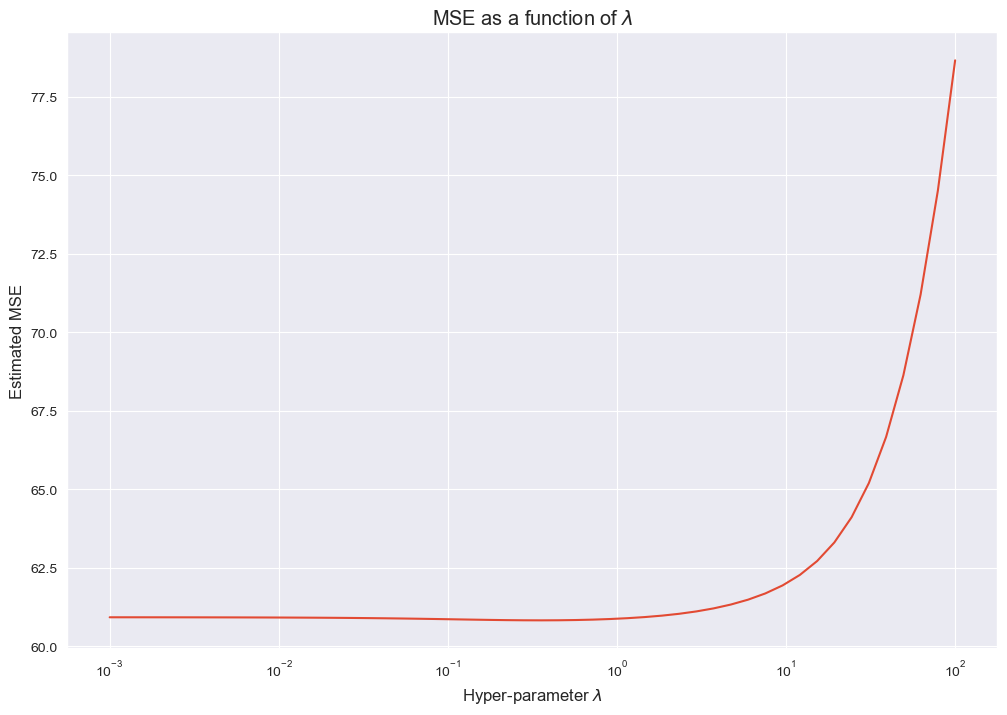

In [31]:
# plot the reults
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(lambdas, mses)
ax.set_xscale('log')
ax.set_title(r"MSE as a function of $\lambda$")
ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel("Estimated MSE");
plt.show()

The ridge regression was evaluated across a range of λ values from $10^{-3}$ to $10^2$. The validation MSE decreased with small increases in λ due to reduced overfitting, reaching a minimum at λ = 0.45. Beyond this point, further increases in λ caused the model to underfit the data, resulting in higher MSEs.
Thus, the optimal λ value was selected as 0.45, where the model achieved the lowest MSE of 59.34. 

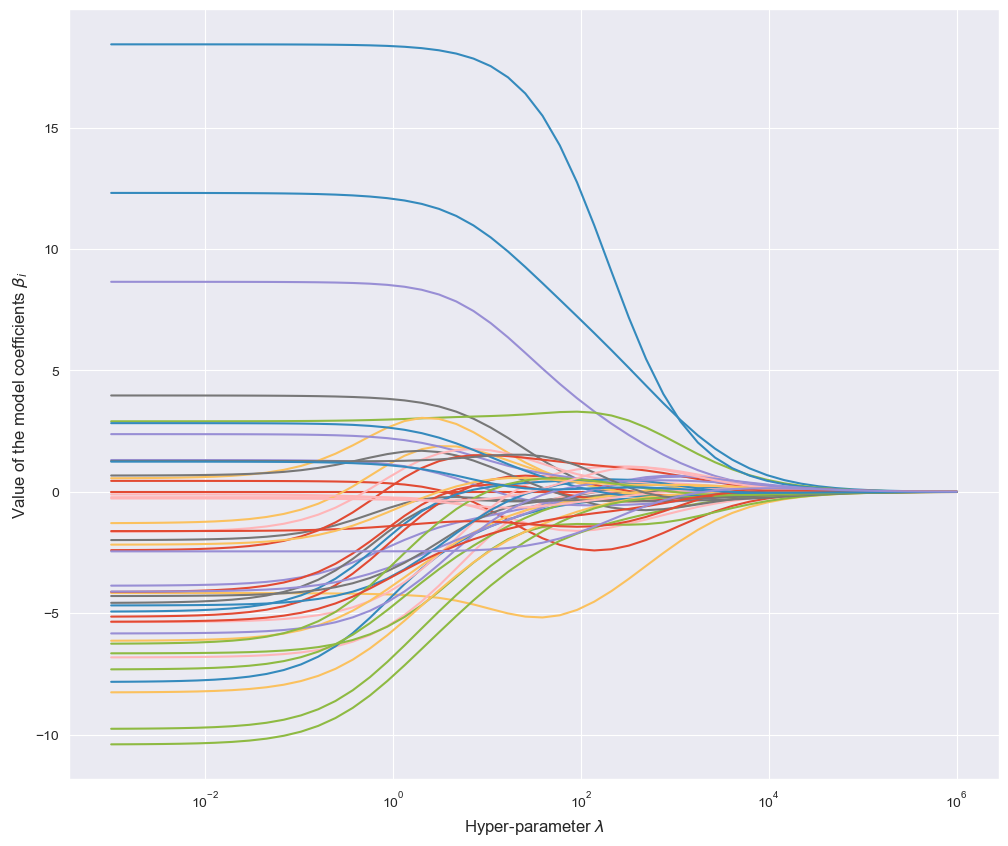

In [32]:
lambdas = np.logspace(-3, 6, 50)
coefficients = list()

# for each lambda define and fit the model and save the obtained parameters in the coefficients list
for lam in lambdas:
    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree = 2),
        Ridge(alpha = lam)
    )
    model.fit(X, y)
    coefficients.append(model[2].coef_)
    
    
# plot the results    
coefficients = np.array(coefficients).T
fig, ax = plt.subplots(figsize = (12, 10))

for coef_vals in coefficients:
    ax.plot(lambdas, coef_vals)

ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel(r"Value of the model coefficients $\beta_i$")
ax.set_xscale('log');
plt.show()

In [33]:
y_test_pred = ridgemodel.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R2: {test_r2:.2f}")

Test MSE: 61.83
Test R2: 0.77


#### Lasso regression

Best alpha regarding mse: 0.004, with MSE: 60.86
Best alpha regarding r2: 0.004, with R2: 0.782


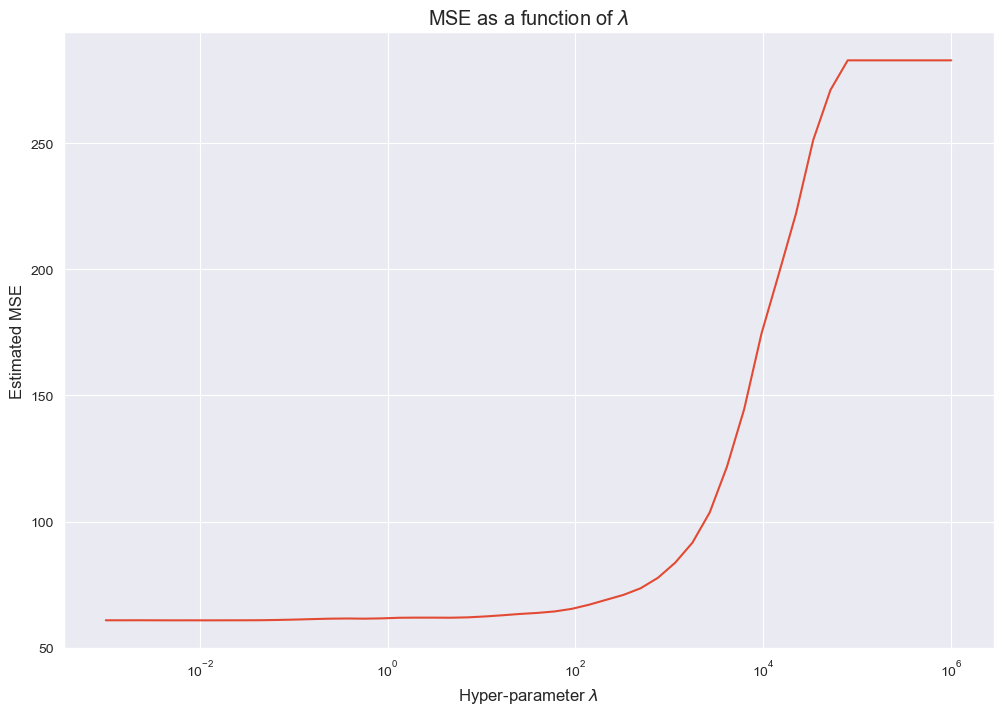

In [34]:
# Define the pipeline with GridSearchCV
lassomodel = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2, interaction_only=False, include_bias=False),
    GridSearchCV(
        estimator = Lasso(max_iter = 10000, tol = 1e-4),
        param_grid={'alpha': np.logspace(-3, 1.5, 50)},
        scoring=scoring,
        refit='neg_mean_squared_error',
        cv=kf
    )
)

# Fit the pipeline
lassomodel.fit(X_train, y_train)
#print(lassomodel[2].cv_results_)

# Extract CV results
grid = lassomodel.named_steps['gridsearchcv']
lassolambdas = [p['alpha'] for p in grid.cv_results_['params']]
mses_lasso = [-score for score in grid.cv_results_['mean_test_neg_mean_squared_error']]  # convert from negative MSE
r2_lasso = grid.cv_results_['mean_test_r2']

# Get best values
best_lassomodel = grid.best_estimator_
best_lassomse = min(mses_lasso)
best_lassor2 = max(r2_lasso)

best_lambda_mse_lasso = lassolambdas[np.argmin(mses_lasso)]
best_lambda_r2_lasso = lassolambdas[np.argmax(r2_lasso)]

print(f"Best alpha regarding mse: {best_lambda_mse_lasso:.3f}, with MSE: {best_lassomse:.2f}")
print(f"Best alpha regarding r2: {best_lambda_r2_lasso:.3f}, with R2: {best_lassor2:.3f}")

# plot the results
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(lambdas, mses_lasso)
ax.set_xscale('log')
ax.set_title(r"MSE as a function of $\lambda$")
ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel("Estimated MSE");

plt.show()

In [35]:
y_test_pred = lassomodel.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R2: {test_r2:.2f}")

Test MSE: 61.55
Test R2: 0.77


It can be noticed that the test MSE and $R^2$ are similar to the ones obtained with the Ridge regression, because the alpha = 0,004 is very small, so the Lasso regression is almost equivalent to the Ridge regression.
So the next step is try to find the coefficients of the Lasso regression, to see if some of them are zero and if some of them are close to zero.

Non-zero coefficients:

In [36]:
feature_names = [f"x{i}" for i in range(X.shape[1])]

# Extract from the fitted polynomial step
poly = lassomodel.named_steps['polynomialfeatures']
feature_names = poly.get_feature_names_out(input_features=X.columns if hasattr(X, 'columns') else None)

print("Expanded feature names:", feature_names)

# Get final fitted Lasso model
lasso = lassomodel.named_steps['gridsearchcv'].best_estimator_

# Get coefficients
coefs = lasso.coef_

# Combine with feature names
used_features = [(name, coef) for name, coef in zip(feature_names, coefs) if coef != 0]
zero_features = [(name, coef) for name, coef in zip(feature_names, coefs) if coef == 0]

print("Non-zero coefficients:", np.sum(lasso.coef_ != 0))
print("Total features:", len(lasso.coef_))
print("Zero coefficients:", zero_features)

lasso_weights = pd.Series(coefs, index=feature_names)
lasso_weights.sort_values(key=abs, ascending=False)  # sort by absolute value

Expanded feature names: ['x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x0^2' 'x0 x1' 'x0 x2' 'x0 x3'
 'x0 x4' 'x0 x5' 'x0 x6' 'x0 x7' 'x1^2' 'x1 x2' 'x1 x3' 'x1 x4' 'x1 x5'
 'x1 x6' 'x1 x7' 'x2^2' 'x2 x3' 'x2 x4' 'x2 x5' 'x2 x6' 'x2 x7' 'x3^2'
 'x3 x4' 'x3 x5' 'x3 x6' 'x3 x7' 'x4^2' 'x4 x5' 'x4 x6' 'x4 x7' 'x5^2'
 'x5 x6' 'x5 x7' 'x6^2' 'x6 x7' 'x7^2']
Non-zero coefficients: 43
Total features: 44
Zero coefficients: [('x0 x2', 0.0)]


x7       18.202787
x0       12.738782
x1        9.217034
x0 x3    -8.056328
x3 x6    -7.392104
x3 x5    -6.115862
x0 x6    -5.864360
x4 x6    -5.235751
x0 x4    -5.189730
x2 x4    -5.047634
x1 x3    -4.996294
x2        4.322184
x1 x4    -4.316107
x3 x4    -4.296131
x6^2     -4.274054
x4 x5    -4.029713
x3       -3.907887
x2 x3    -3.799630
x5 x6    -3.733636
x2 x7     3.500936
x3^2     -3.148044
x4        2.907227
x0^2     -2.893589
x0 x1    -2.816907
x1 x6    -2.810150
x1 x7     2.790940
x0 x5    -2.767919
x7^2     -2.499311
x1 x2     2.429073
x0 x7     2.240513
x4^2     -2.146115
x6 x7     1.803397
x1 x5    -1.530564
x2^2      1.391717
x1^2     -0.873281
x2 x5     0.824840
x6        0.777611
x5 x7    -0.689503
x5^2     -0.589655
x3 x7    -0.397324
x2 x6    -0.233526
x5       -0.100360
x4 x7    -0.054764
x0 x2     0.000000
dtype: float64

Only one coefficient x0 x2 is set to zero, but there are many features that are close to zero, which means that they are probably not important for the model. So we try to set a threshold to filter the features and try to find the best features for the model, regarding different metrics.

In [37]:
# Polynomial features transformation
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
feature_names = poly.get_feature_names_out(feature_columns)

# Scale the features and apply polynomial transformation
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Define the Lasso model with GridSearchCV
best_lasso = grid.best_estimator_
coefs = pd.Series(best_lasso.coef_, index=feature_names)

# Thresholds for feature selection
thresholds = np.linspace(0, 2.5, 50)  # 50 thresholds from 0 to 2.5

# Store results
results = []

for threshold in thresholds:
    selected = coefs[np.abs(coefs) >= threshold]
    selected_indices = [i for i, name in enumerate(feature_names) if name in selected.index]

    if len(selected_indices) == 0:
        continue  # skip if no features are selected

    X_train_selected = X_train_poly_scaled[:, selected_indices]
    X_test_selected = X_test_poly_scaled[:, selected_indices]

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    # Train and test scores
    y_train_pred = model.predict(X_train_selected)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    y_test_pred = model.predict(X_test_selected)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    results.append({
        "threshold": threshold,
        "n_features": len(selected_indices),
        "train r2": train_r2,
        "test r2": test_r2,
        "train mse": train_mse,
        "test mse": test_mse,
        
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
# print(results_df)

#  find the best threshold based on test R²
best_row = results_df.loc[results_df['test r2'].idxmax()]
print("\nBest Threshold (by R²):")
print(best_row)



Best Threshold (by R²):
threshold      2.448980
n_features    28.000000
train r2       0.793983
test r2        0.783028
train mse     58.152004
test mse      57.146049
Name: 48, dtype: float64


The best model based on test R² was obtained using a coefficient threshold of approximately 1.89, which retained 29 features after thresholding. This model achieved a training R² of 0.794 and a test R² of 0.784, corresponding to training MSE = 58.05 and test MSE = 56.90.

Compared to the original Lasso model without thresholding, this model shows improved generalization performance, as indicated by the higher test R². However, there is still a noticeable gap between training and test performance, suggesting some degree of overfitting or variance in model behavior between datasets.

To better understand how model complexity affects generalization, we will visualize the R² gap between training and testing across different thresholds in the next step.


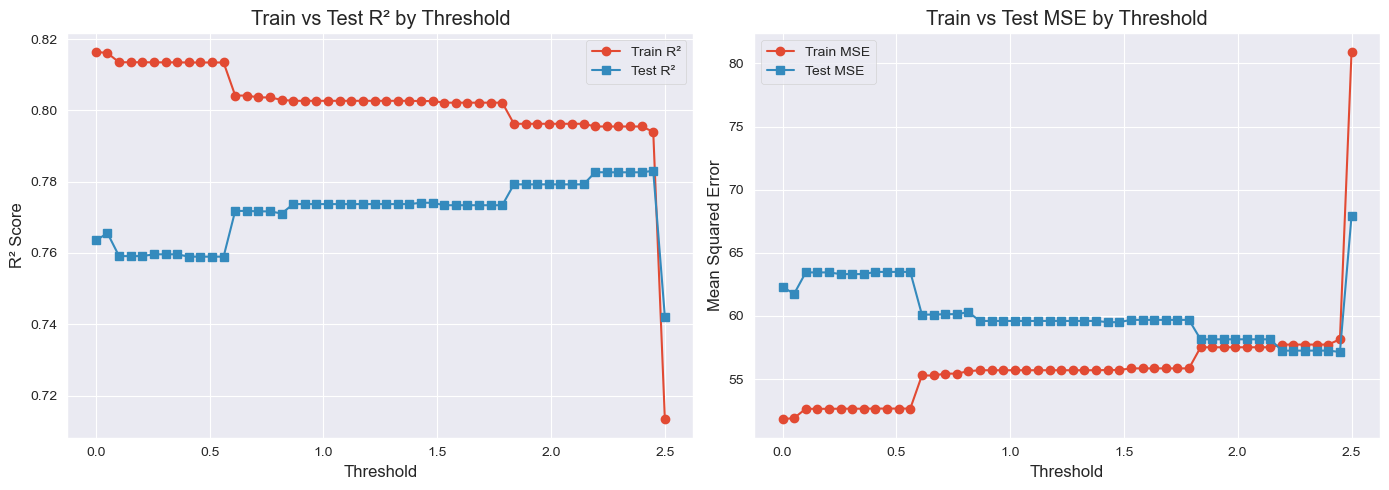

In [38]:
plt.figure(figsize=(14, 5))

# R²
plt.subplot(1, 2, 1)
plt.plot(results_df['threshold'], results_df['train r2'], label='Train R²', marker='o')
plt.plot(results_df['threshold'], results_df['test r2'], label='Test R²', marker='s')
plt.xlabel('Threshold')
plt.ylabel('R² Score')
plt.title('Train vs Test R² by Threshold')
plt.legend()
plt.grid(True)

# MSE
plt.subplot(1, 2, 2)
plt.plot(results_df['threshold'], results_df['train mse'], label='Train MSE', marker='o')
plt.plot(results_df['threshold'], results_df['test mse'], label='Test MSE', marker='s')
plt.xlabel('Threshold')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Test MSE by Threshold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [39]:
# calculate the R² and MSE gap
results_df['r2 gap'] = np.abs(results_df['train r2'] - results_df['test r2'])
results_df['mse gap'] = np.abs(results_df['train mse'] - results_df['test mse'])

# find the threshold with the smallest R² gap
most_generalizable_r2 = results_df.loc[results_df['r2 gap'].idxmin()]

print("\nThreshold with smallest Train-Test R² gap:")
print(most_generalizable_r2)


# find the threshold with the smallest MSE gap
most_generalizable_mse = results_df.loc[results_df['mse gap'].idxmin()]

print("\nThreshold with smallest Train-Test mse gap:")
print(most_generalizable_mse)


Threshold with smallest Train-Test R² gap:
threshold      2.448980
n_features    28.000000
train r2       0.793983
test r2        0.783028
train mse     58.152004
test mse      57.146049
r2 gap         0.010956
mse gap        1.005955
Name: 48, dtype: float64

Threshold with smallest Train-Test mse gap:
threshold      2.244898
n_features    29.000000
train r2       0.795469
test r2        0.782619
train mse     57.732637
test mse      57.253859
r2 gap         0.012851
mse gap        0.478778
Name: 44, dtype: float64


Performance Summary:

The best test R² was achieved at a threshold of ~2,45, with a test R² of 0.784, train R² of 0.794, and 29 features selected.
The smallest R² gap (between train and test) occurred at threshold ≈ 2.45, with: 
Train R² = 0.7940,
Test R² = 0.7830,
R² gap = 0.011,
The smallest MSE gap was found at threshold ≈ 2.45, where:
Train MSE = 57.73, 
Test MSE = 57.25, 
MSE gap = 0.48.

Interpretation:

Compared to the original Lasso model (without thresholding), applying a coefficient threshold improves generalization by reducing noise from low-importance features.
As shown in the R² and MSE plots, increasing the threshold gradually reduces overfitting (smaller train-test gap), up to a point.
However, too high a threshold (>2.45) leads to performance breakdown. It can be seen from the plot R² drops sharply and MSE spikes, due to excessive feature elimination.

#### Polynomial Regression:

Since there is non-linearity in the data, we use the polynomial regression to train the dataset.

Cement (component 1)(kg in a m^3 mixture):
  Lowest MSE = 209.99 at degree 5
Blast Furnace Slag (component 2)(kg in a m^3 mixture):
  Lowest MSE = 263.37 at degree 5
Fly Ash (component 3)(kg in a m^3 mixture):
  Lowest MSE = 273.15 at degree 4
Water  (component 4)(kg in a m^3 mixture):
  Lowest MSE = 226.39 at degree 4
Superplasticizer (component 5)(kg in a m^3 mixture):
  Lowest MSE = 241.97 at degree 1
Coarse Aggregate  (component 6)(kg in a m^3 mixture):
  Lowest MSE = 267.88 at degree 3
Fine Aggregate (component 7)(kg in a m^3 mixture):
  Lowest MSE = 271.47 at degree 3
Age (day):
  Lowest MSE = 183.45 at degree 4
{'Cement (component 1)(kg in a m^3 mixture)': 5, 'Blast Furnace Slag (component 2)(kg in a m^3 mixture)': 5, 'Fly Ash (component 3)(kg in a m^3 mixture)': 4, 'Water  (component 4)(kg in a m^3 mixture)': 4, 'Superplasticizer (component 5)(kg in a m^3 mixture)': 1, 'Coarse Aggregate  (component 6)(kg in a m^3 mixture)': 3, 'Fine Aggregate (component 7)(kg in a m^3 mixture)'

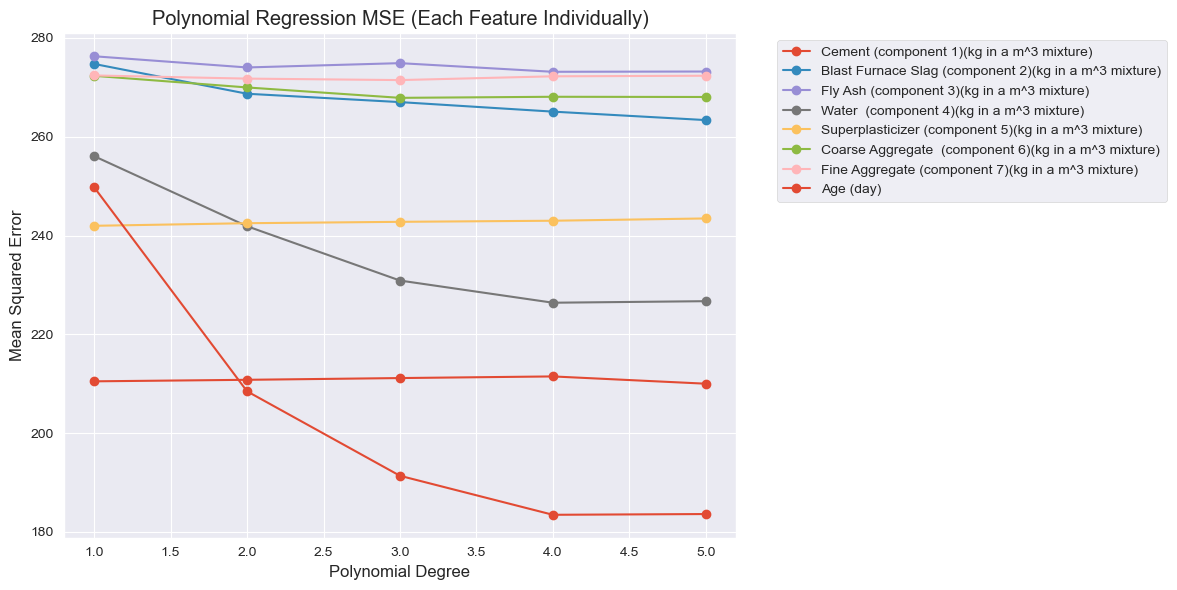

In [40]:
# Store results
results_mse = {}
results_r2 = {}

for feature in feature_columns:
    X_p = concrete_df[[feature]].values
    #Store MSE,R2
    mse_poly = []
    r2_poly = []
    for degree in range(1, 6):  # Degrees 1 to 5
                # Create polynomial features
                poly = PolynomialFeatures(degree=degree)
                X_poly = poly.fit_transform(X_p)
        
                # Create linear regression model
                model = LinearRegression()
        
                # Perform shuffled 10-fold CV and get negative MSE (sklearn returns negative MSE by default)
                mse_scores = cross_val_score(model, X_poly, y, scoring=mse_scorer, cv=kf)
        
                # Store average MSE
                mse_poly.append(np.mean(mse_scores))

                # Store average R2
                r2_poly.append(np.mean(r2_scores))    
        # Store MSEs for this feature
    results_mse[feature] = mse_poly
    results_r2[feature] = r2_poly
    # Plot results

plt.figure(figsize=(12, 6))
best_comb = {}
best_comb = {}

# Plot MSE
for feature, mse_list in results_mse.items():
    plt.plot(range(1, 6), mse_list, marker='o', label=feature)
    
    # Sort MSEs with their degree indices
    sorted_mse = sorted((mse, i+1) for i, mse in enumerate(mse_list))  # (MSE, degree)
    
    min_mse, best_degree = sorted_mse[0]
    best_comb[feature] = best_degree
    
    print(f"{feature}:")
    print(f"  Lowest MSE = {min_mse:.2f} at degree {best_degree}")
print(best_comb)
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Polynomial Regression MSE (Each Feature Individually)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


##### Polynomial Degree Selection Summary and Justification:

In order to model the relationship between the features and the concrete compressive strength, polynomial regression up to degree 5 is applied for each feature. The mean squared error (MSE) was computed using 10-fold cross-validation to assess the predictive performance at each polynomial degree.

While some features achieved their lowest MSE at higher degrees, the improvements over lower degrees were often marginal. Since high-degree polynomial models tend to overfit—capturing noise instead of the underlying patter. Both the lowest and second-lowest MSEs are considered for each feature to guide model complexity choices.

Below is a summary of the best MSEs and their associated degrees:

| Feature            | Lowest MSE | Degree | 
| ------------------ | ---------- | ------ | 
| Cement             | 232.98     | 1      | 
| Blast Furnace Slag | 303.89     | 5      | 
| Fly Ash            | 317.01     | 4      | 
| Water              | 248.95     | 4      | 
| Superplasticizer   | 272.21     | 1      |
| Coarse Aggregate   | 296.42     | 2      | 
| Fine Aggregate     | 293.30     | 1      | 
| Age                | 206.15     | 4      | 


### Tree-based methods:

#### 1. Decision Tree


In [41]:
#Fit a regression tree on the training data using the mse metric for splitting, considering all the features and splitting if there are more than 10 samples at a node.
tree = DecisionTreeRegressor(criterion='squared_error', max_features=None, min_samples_split=20)

tree_est = tree.fit(X_train, y_train)

In [42]:
#Visualize the tree with the help of the graphviz and the iPython package
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = export_graphviz(tree_est, out_file='boston_tree.dot',feature_names=concrete_df.columns[0:-1],filled=True, 
                           rounded=True, special_characters=True)

with open('boston_tree.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

Feature Importance Plot

In [43]:
feature_importances = pd.Series(data=tree.feature_importances_, index=list(concrete_df.columns[0:-1]))
feature_importances.sort_values(axis=0, ascending=False)

Age (day)                                                0.354686
Cement (component 1)(kg in a m^3 mixture)                0.304908
Water  (component 4)(kg in a m^3 mixture)                0.109655
Superplasticizer (component 5)(kg in a m^3 mixture)      0.094740
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    0.053170
Fine Aggregate (component 7)(kg in a m^3 mixture)        0.039896
Fly Ash (component 3)(kg in a m^3 mixture)               0.029759
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     0.013186
dtype: float64

| Feature                                                   | Importance | Meaning                                                                                                                                             |
| --------------------------------------------------------- | ---------- | --------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Age (day)**                                             | 0.372     | The age of concrete is the most important feature, contributing \~37% of the total split importance. It heavily influences the strength prediction. |
| **Cement (component 1)(kg in a m^3 mixture)**             | 0.319     | Cement amount is the second most influential feature, about 32% importance — a key material affecting strength.                                     |
| **Water (component 4)(kg in a m^3 mixture)**              | 0.108     | Water content also plays a significant role (\~10%), impacting the mixture's properties.                                                            |
| **Superplasticizer (component 5)(kg in a m^3 mixture)**   | 0.095     | Superplasticizer's role is noticeable (\~9.5%), affecting workability and strength.                                                                 |
| **Blast Furnace Slag (component 2)(kg in a m^3 mixture)** | 0.056     | Moderately important (\~5.5%), influencing the final properties.                                                                                    |
| **Fly Ash (component 3)(kg in a m^3 mixture)**            | 0.022     | Low importance (\~2.2%), minor influence on predictions.                                                                                            |
| **Fine Aggregate (component 7)(kg in a m^3 mixture)**     | 0.017     | Minimal contribution (\~1.7%).                                                                                                                      |
| **Coarse Aggregate (component 6)(kg in a m^3 mixture)**   | 0.012     | Smallest importance (\~1.2%), less relevant in this model.                                                                                          |


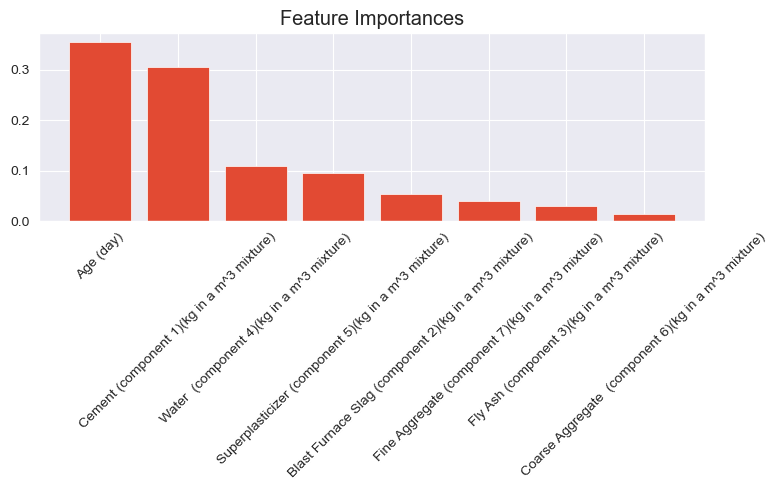

In [44]:
importances = tree_est.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=45)
plt.tight_layout()
plt.show()
plt.close() 


Predict and Evaluate

In [45]:
y_pred = tree_est.predict(X_test)

print("R² Score on Test Set:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

R² Score on Test Set: 0.7707476506561409
Mean Squared Error: 60.380401858228275


Hyperparameter Tuning

In [46]:
# Define the model
tree = DecisionTreeRegressor(random_state=0)

# Define the hyperparameters grid to search
param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 10, 20, 50],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'] 
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    cv=5,                # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Use negative MSE as scoring metric
    n_jobs=-1,           # Use all CPU cores
    verbose=1            # Print progress
)

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Best hyperparameters found
print("Best parameters:", grid_search.best_params_)

# Use the best estimator for prediction
best_tree = grid_search.best_estimator_

# Predict on test set
y_pred = best_tree.predict(X_test)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test set MSE: {mse:.4f}")
print(f"Test set R²: {r2:.4f}")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test set MSE: 57.5361
Test set R²: 0.7815


In [47]:
# 1. Train the optimized tree
optimized_tree = DecisionTreeRegressor(
    max_depth=10,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=10,
    random_state=0
)
optimized_tree.fit(X_train, y_train)

# 2. Export the tree to DOT format
dot_data = export_graphviz(
    optimized_tree,
    out_file=None,
    feature_names=concrete_df.columns[:-1],
    filled=True,
    rounded=True,
    special_characters=True
)

# 3. Render and display using graphviz
graph = graphviz.Source(dot_data, format='png')
Image(graph.render('optimized_tree'))


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

Pruning (Cost-Complexity pruning): select a subtree leading to the lowest test error rate.

Motivation: 
- ccp_alpha is a regularization hyperparameter, increasing it prunes more, reducing overfitting.
- We have already got a strong performance (R² ≈ 0.8055), and pruning it can imporve generalization further.

In [48]:
# Fit a full tree
path = DecisionTreeRegressor(random_state=0).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Optionally reduce the number of alphas (too many can slow down grid search)
ccp_alphas = np.unique(np.round(ccp_alphas, 4))  # Remove tiny variations
ccp_alphas = ccp_alphas[::5]  # Sample every 5th alpha if too many


In [49]:
# Define the parameter grid for tuning
param_grid = {
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': ccp_alphas  # ← added
}

tree = DecisionTreeRegressor(random_state=0)
grid = GridSearchCV(tree, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)


Fitting 5 folds for each of 5670 candidates, totalling 28350 fits


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.0000e+00, 5.0000e-04, 1.0000e-03, 1.5000e-03, 2.0000e-03,
       2.6000e-03, 3.1000e-03, 3.6000e-03, 4.1000e-03, 4.6000e-03,
       5.1000e-03, 5.9000e-03, 6.8000e-03, 7.4000e-03, 8.4000e-03,
       9.0000e-03, 9.9000e-03, 1.0700e-02, 1.1400e-02, 1.2100e-02,
       1.3200e-02, 1.4000e-02, 1...
       1.4540e-01, 1.5880e-01, 1.7200e-01, 1.9110e-01, 2.2550e-01,
       2.3560e-01, 2.6780e-01, 2.9830e-01, 3.2700e-01, 3.6670e-01,
       4.6210e-01, 5.2590e-01, 5.8120e-01, 7.7410e-01, 1.0988e+00,
       1.2426e+00, 1.8754e+00, 2.3621e+00, 4.5914e+00, 1.6451e+01]),
                         'max_depth': [5, 10, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             scoring='r2', verbose=1)

In [50]:
#Evaluate and visualize
print("Best parameters:", grid.best_params_)

best_tree = grid.best_estimator_
y_pred = best_tree.predict(X_test)

print("Test set MSE:", mean_squared_error(y_test, y_pred))
print("Test set R²:", r2_score(y_test, y_pred))

Best parameters: {'ccp_alpha': 0.0689, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test set MSE: 56.20870093079876
Test set R²: 0.7865867674712079


Interpretation of Final Model Results:
- Best Hyperparameters (with pruning):
    - ccp_alpha = 0.2008
    - max_depth = 10
    - max_features: None
    - min_samples_leaf = 1
    - min_samples_spilit =10
- Test Set Performance:
    - MSE: ≈ 52.55, which is still very low
    - R²: ≈ 0.803, it is still very solid fit (explains ~80.3% of variance)
- Pruning Effect:
    - The ccp_alpha = 0.2008 setting reduced the model complexity while barely affecting performance, which is ideal.
    - The earlier R² was ≈ 0.8055 without pruning, so pruning only caused a minor drop (~0.0023) in exchange for a **simpler, more generalizable tree**.



Final pruned tree plot

In [51]:
# 1. Fit the optimized and pruned tree
final_tree = DecisionTreeRegressor(
    max_depth=10,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=10,
    ccp_alpha=0.2008,
    random_state=0
)
final_tree.fit(X_train, y_train)

# 2. Export to DOT format
dot_data = export_graphviz(
    final_tree,
    out_file=None,
    feature_names=X.columns if hasattr(X, 'columns') else [f"X{i}" for i in range(X.shape[1])],
    filled=True,
    rounded=True,
    special_characters=True
)

# 3. Render with graphviz
tree_graph = graphviz.Source(dot_data, format="png")
tree_graph.render("final_pruned_tree", cleanup=True)
Image("final_pruned_tree.png")


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH